# Internal-External Development and Cross-Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'yardstick'

The following object is masked from 'package:readr':

    spec

Loading required package: rms
Loading required package: Hmisc

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

# Logistic Model

In [ ]:
library(rsample) # for group_vfold_cv()
library(furrr) # for future_map()


Loading required package: future

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()    masks purrr::discard()
✖ dplyr::filter()      masks stats::filter()
✖ recipes::fixed()     masks stringr::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ yardstick::spec()    masks readr::spec()
✖ Hmisc::src()         masks dplyr::src()
✖ recipes::step()      masks stats::step()
✖ Hmisc::summarize()   masks dplyr::summarize()
✖ parsnip::translate() masks Hmisc::translate()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

[[1]]

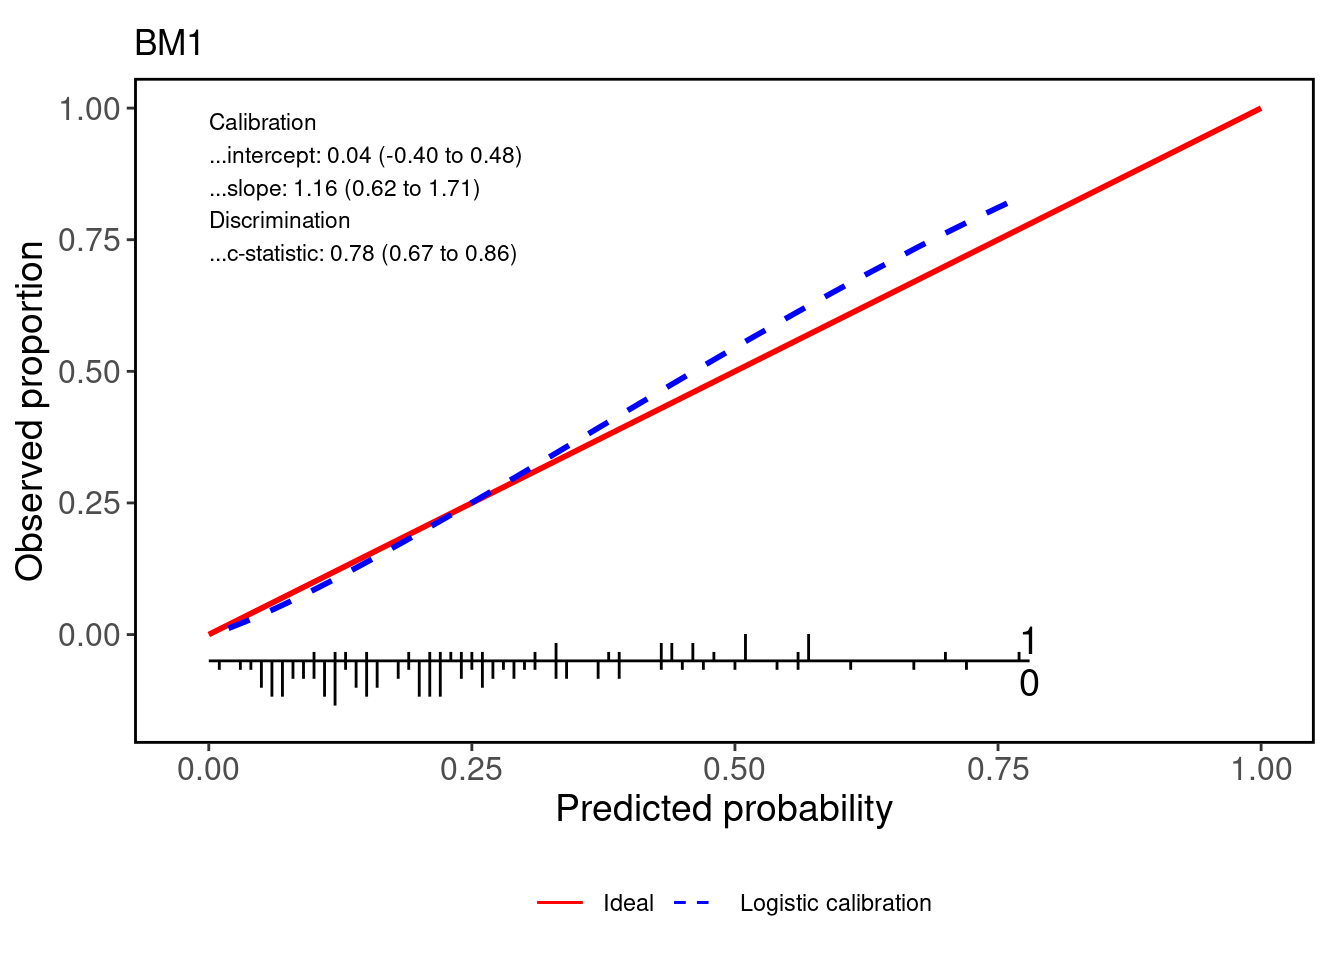


[[2]]

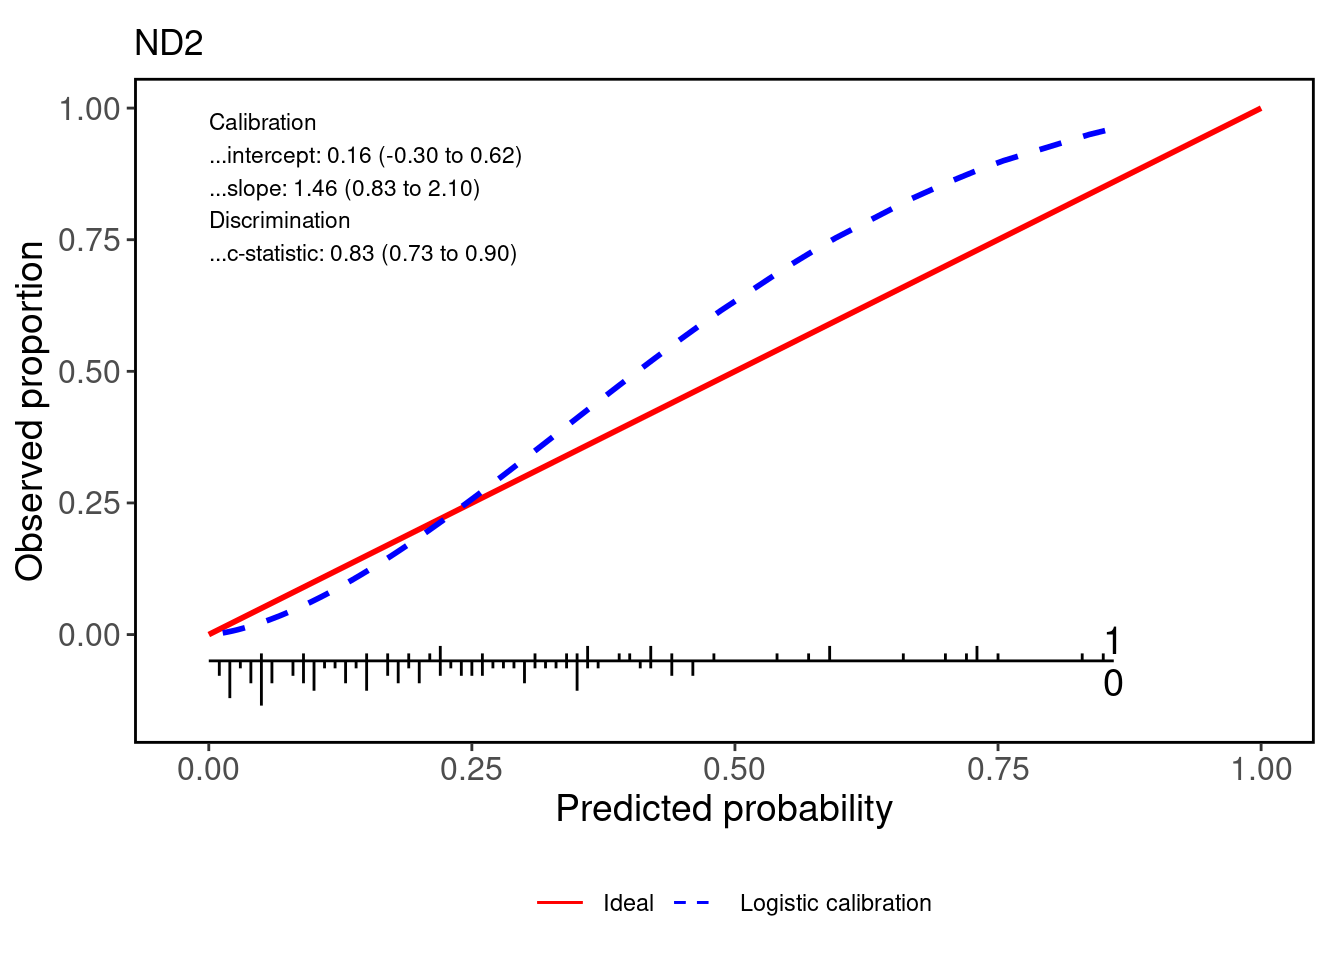


[[3]]

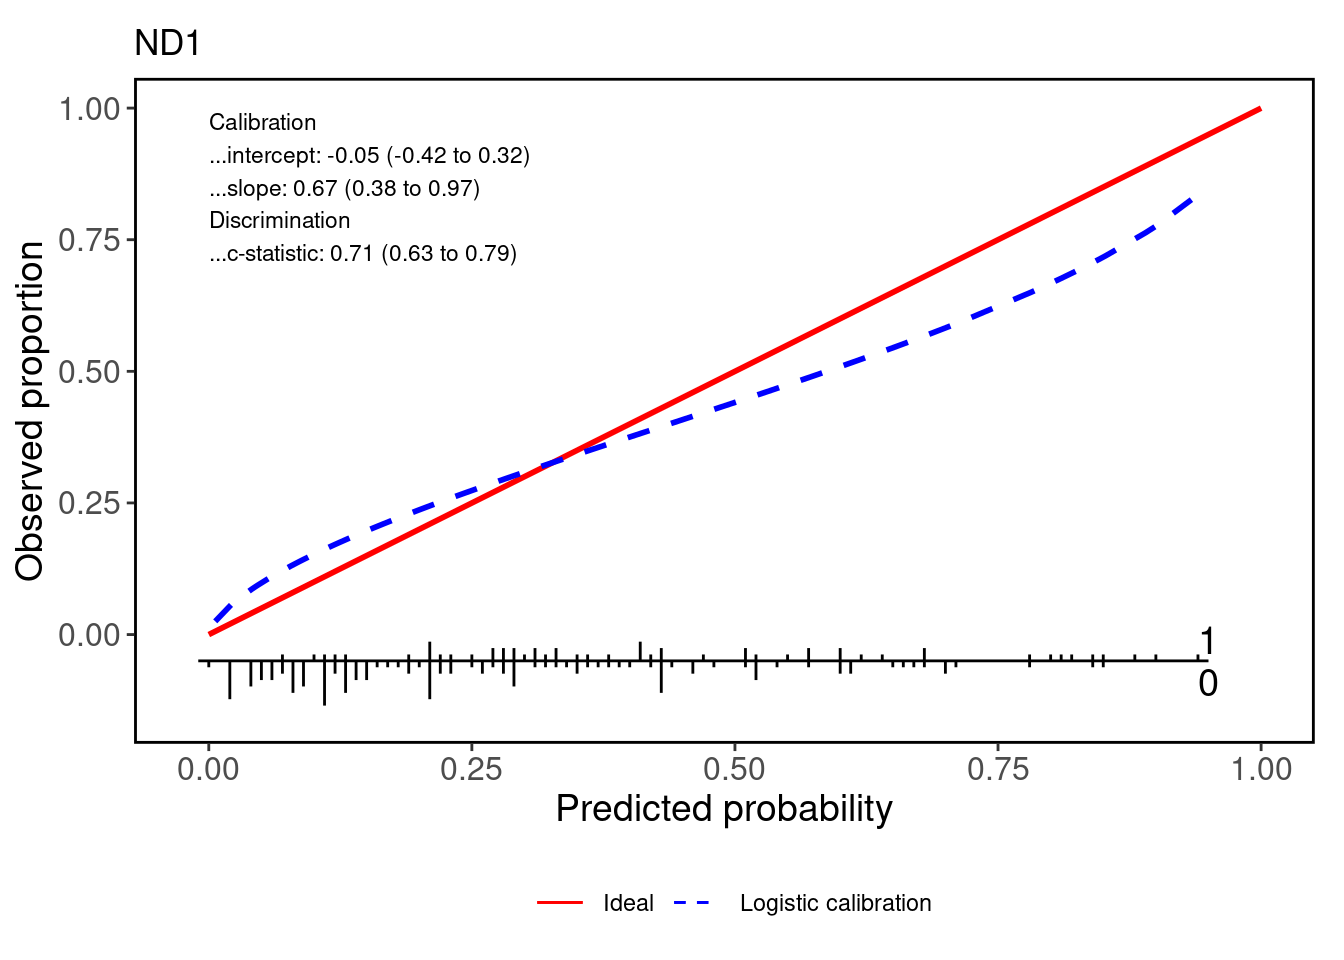


[[4]]

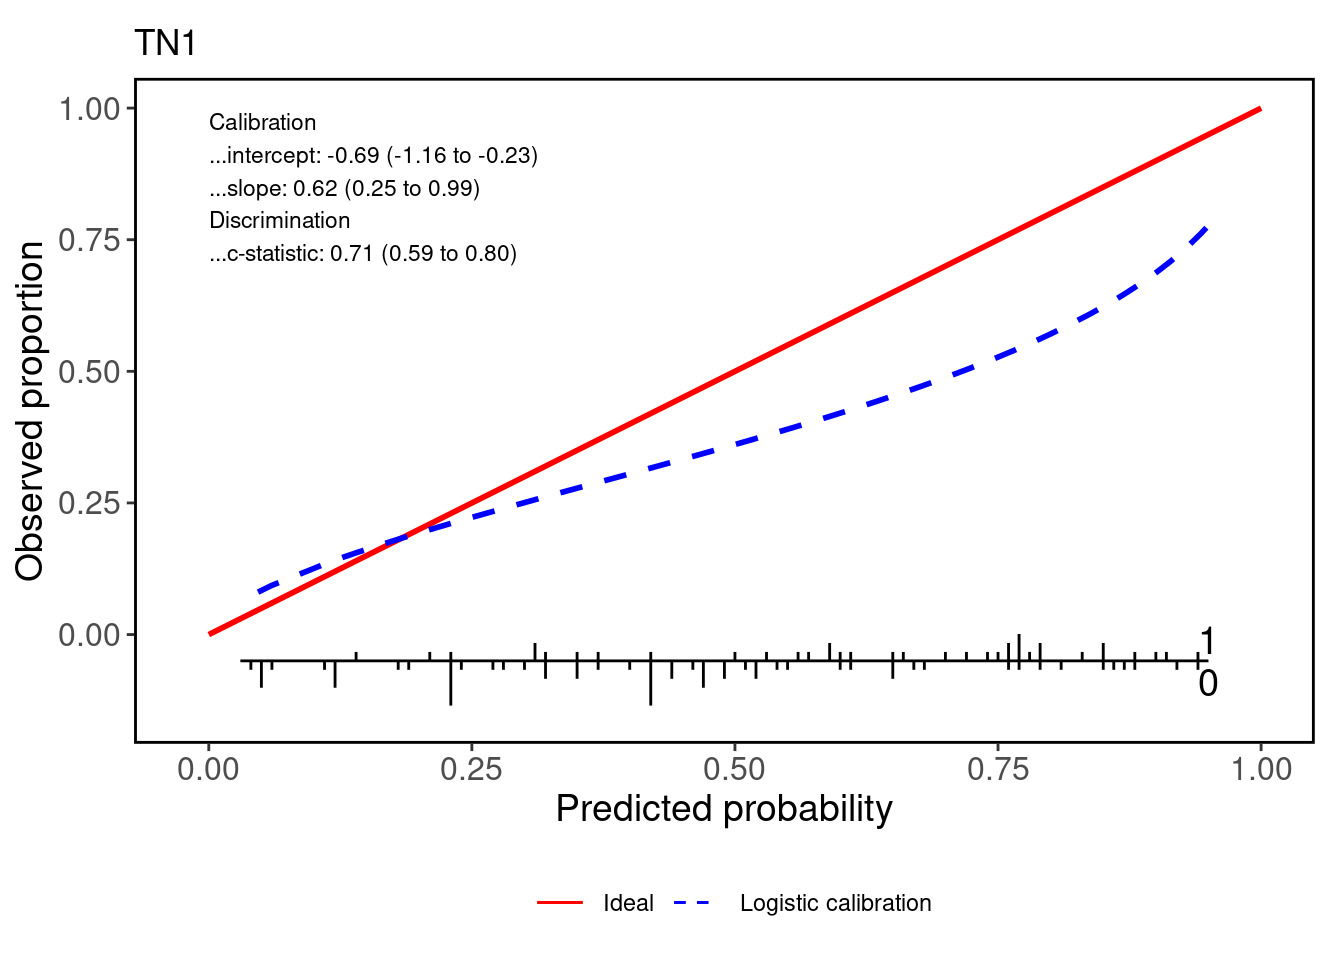


[[5]]

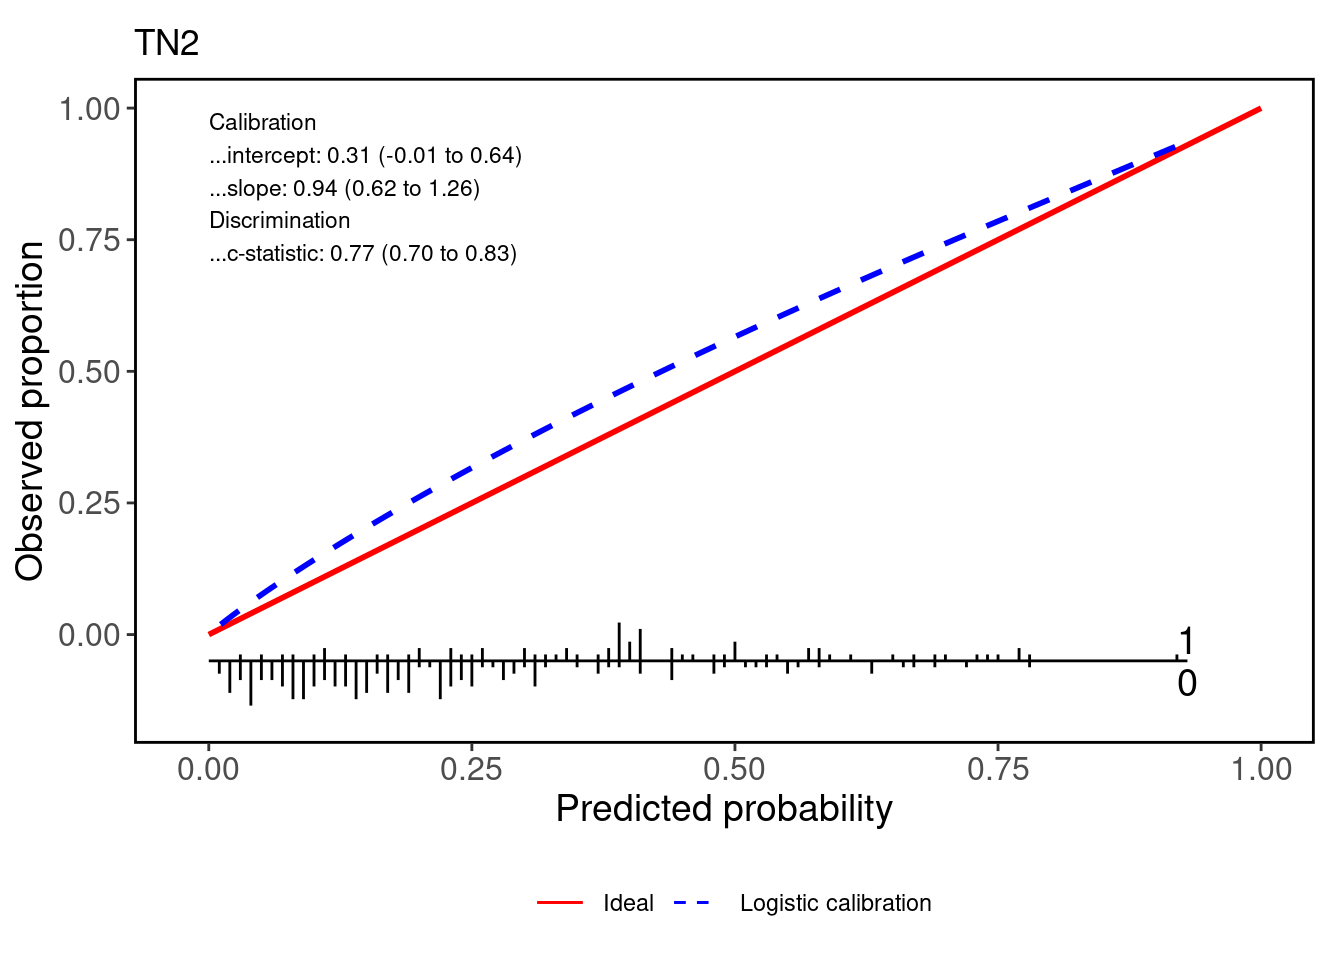


[[6]]

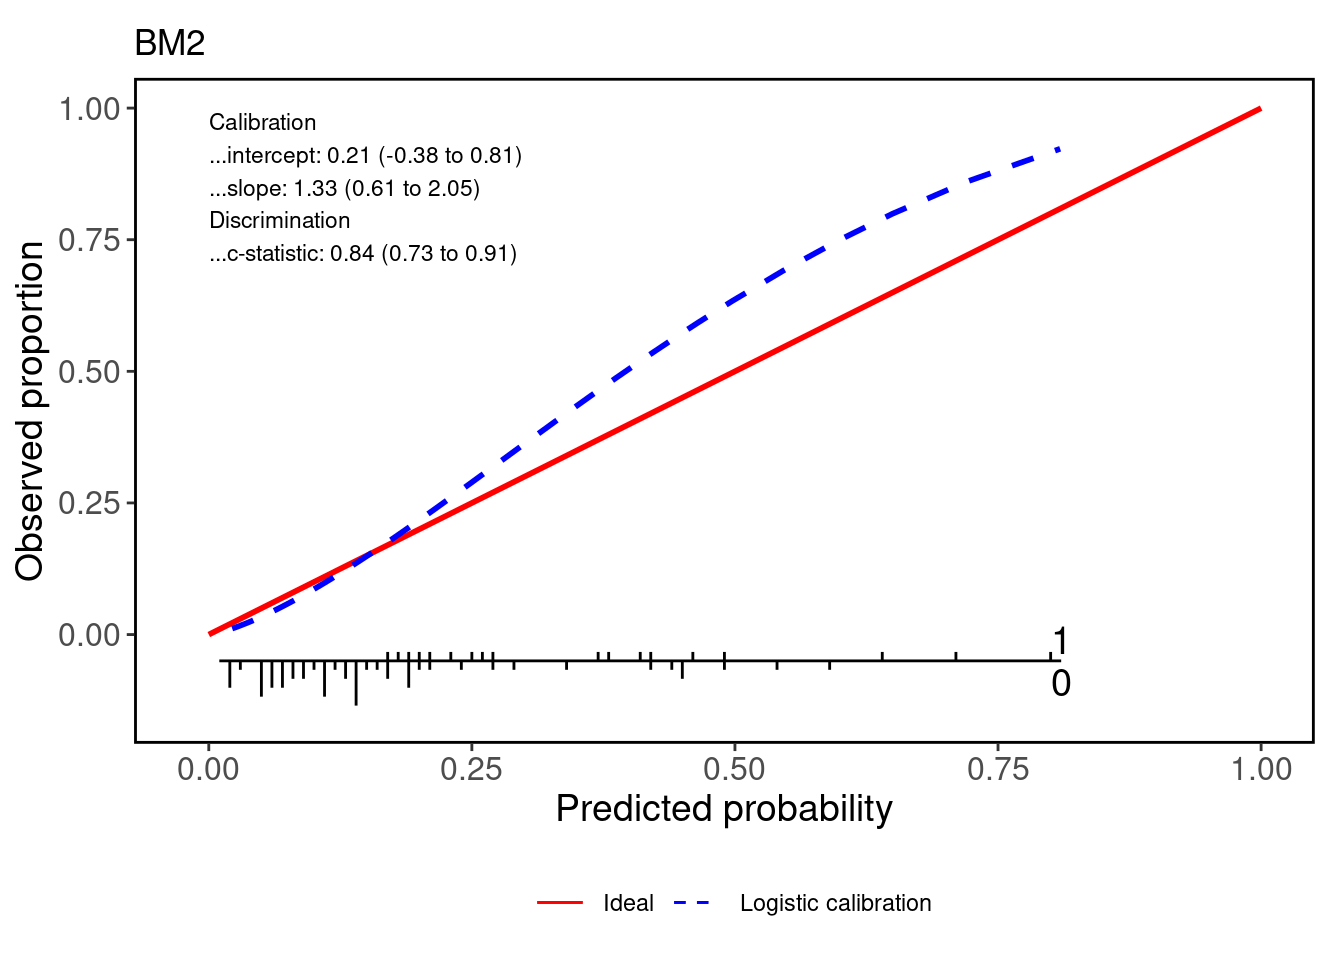

In [ ]:
cross_plots_BPM


In [ ]:
# cross_plots_HPM


In [ ]:
library(meta)


Loading required package: metadat

Loading 'meta' package (version 7.0-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs

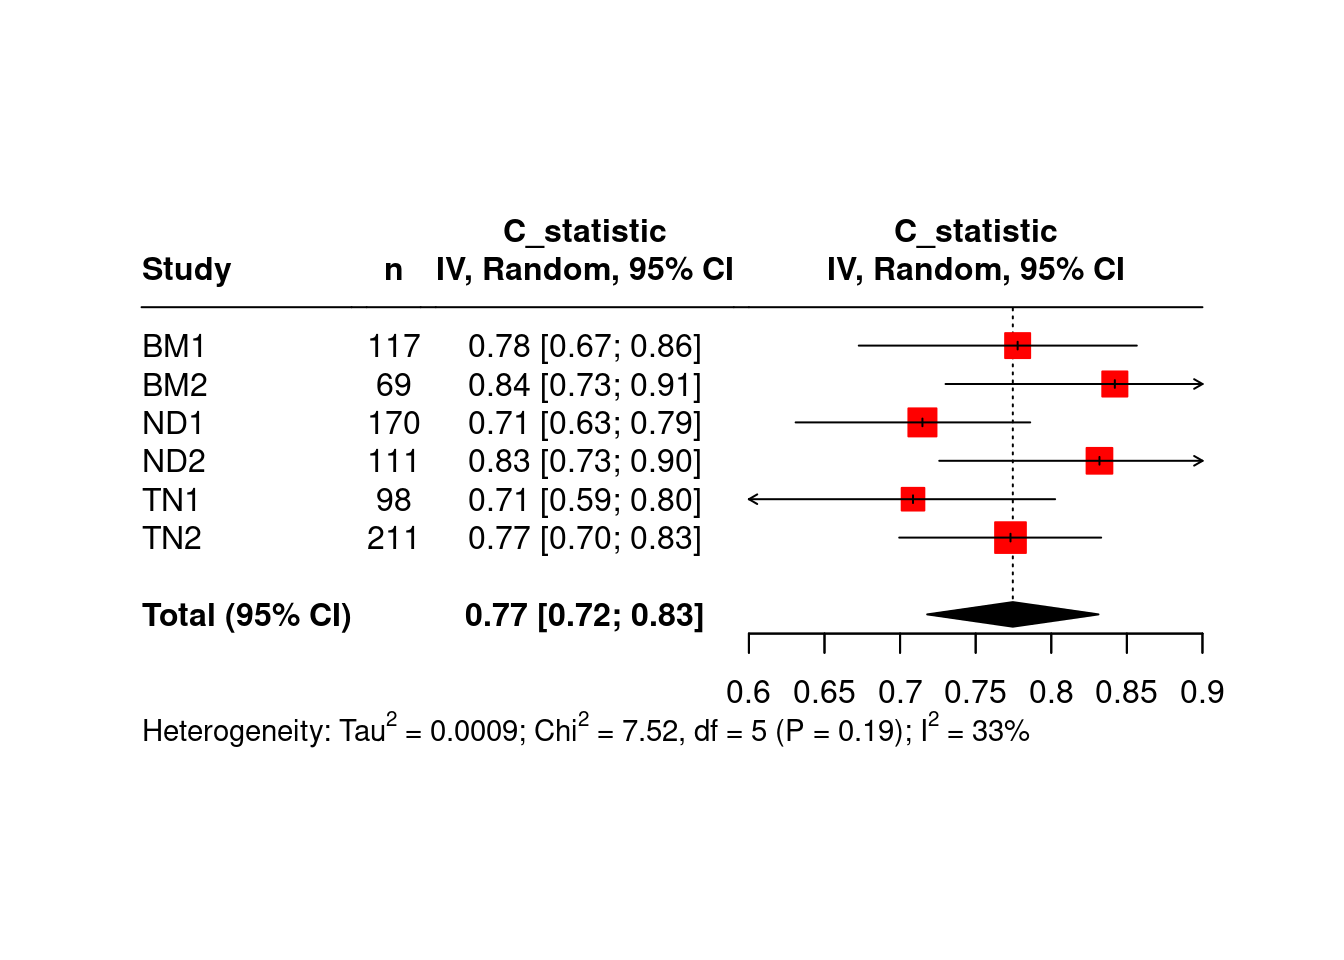

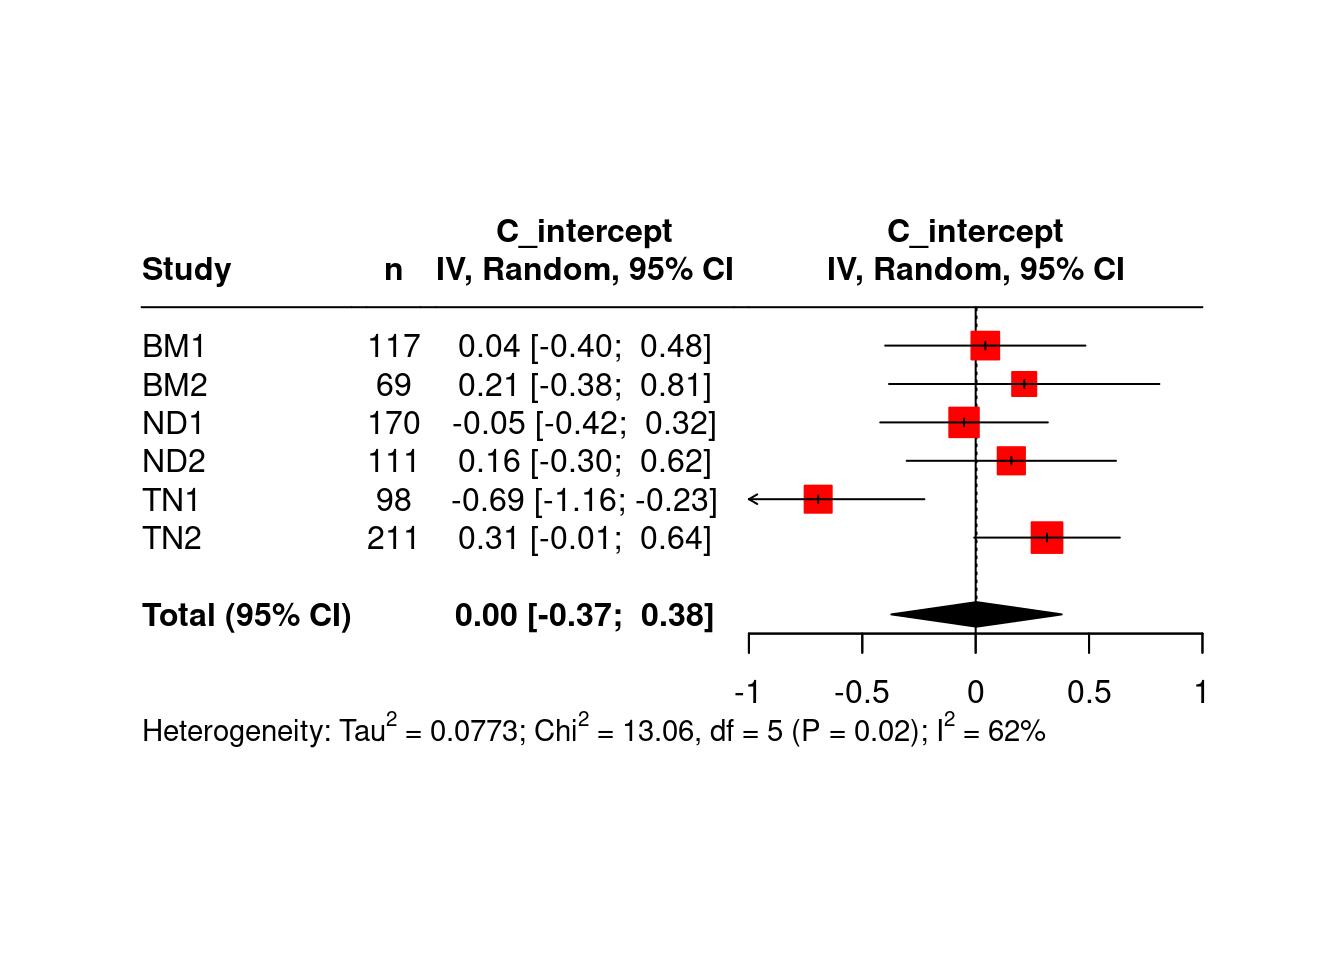

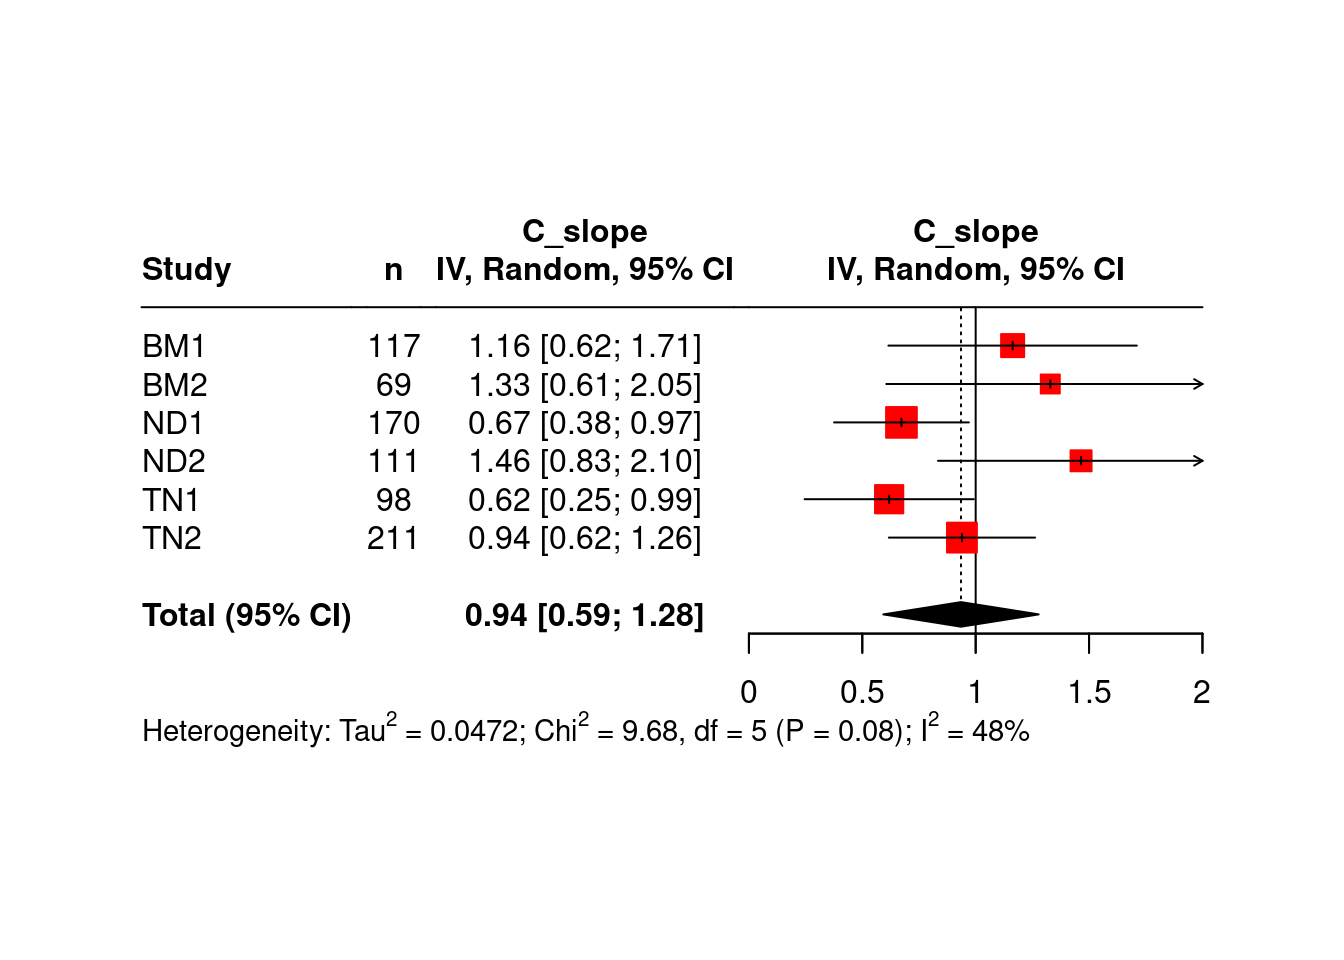

In [ ]:
library(meta)

cross_C_index_meta_BPM <- metagen(
  data = cross_estimates_BPM,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

forest_plot_C_index_BPM <- forest(
  cross_C_index_meta_BPM,
  sortvar = studlab,
  ref = NA,
  xlim = c(0.6, 0.9),
  leftcols = c("studlab", "n", "effect.ci"),
  addrows.below.overall = 2,
  layout = "RevMan5"
)


In [ ]:
# save(cross_performance_metrics_HPM, file = "data/model-performance/cross-performance-metrics-HPM.rda")
save(cross_performance_metrics_BPM, file = "data/model-performance/cross-performance-metrics-BPM.rda")


# BMA Black Box (from “consensus” variables)

[[1]]

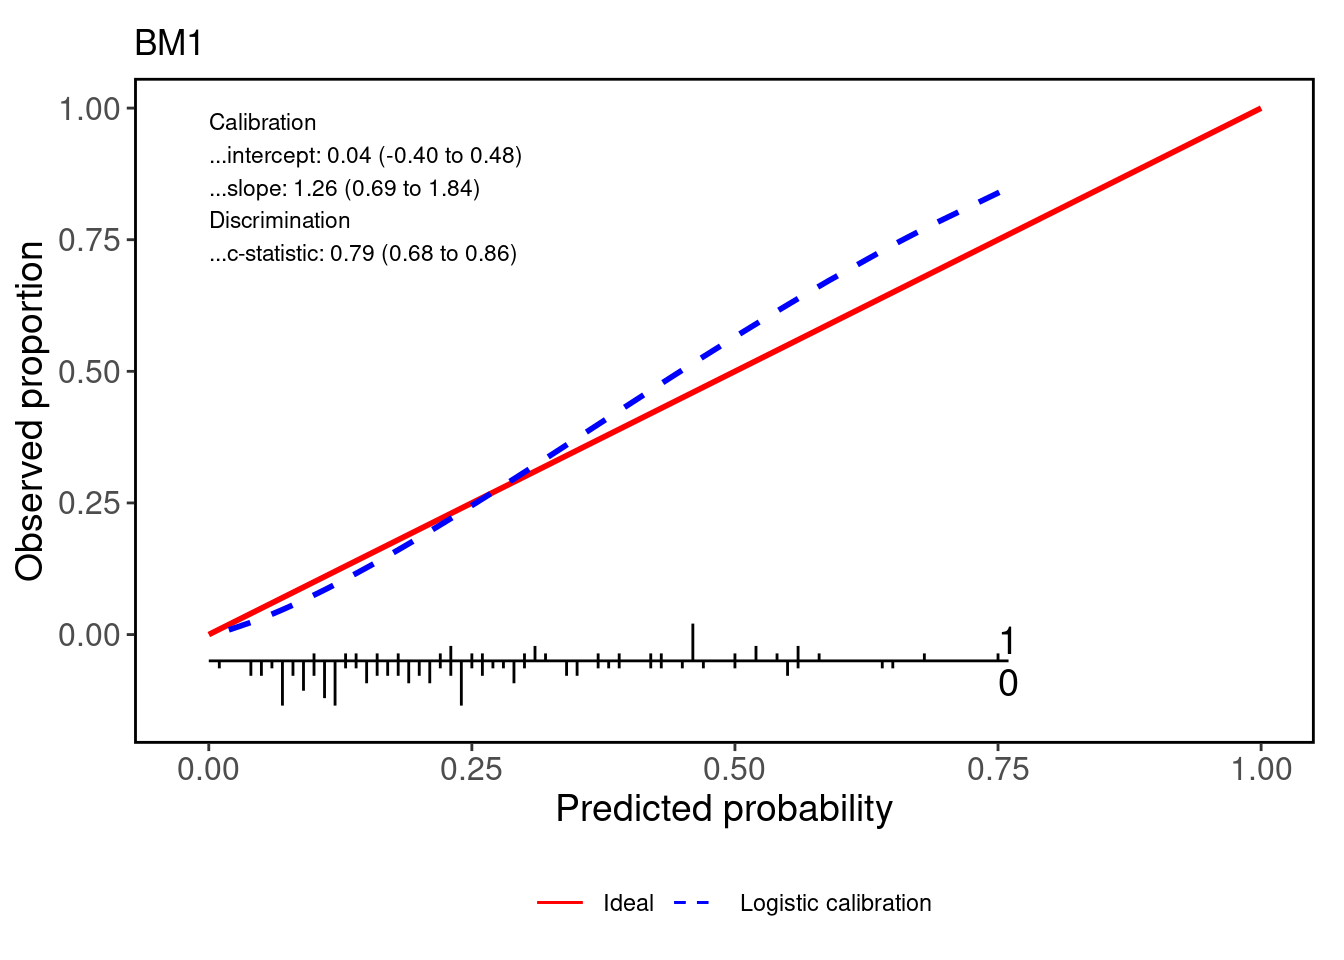


[[2]]

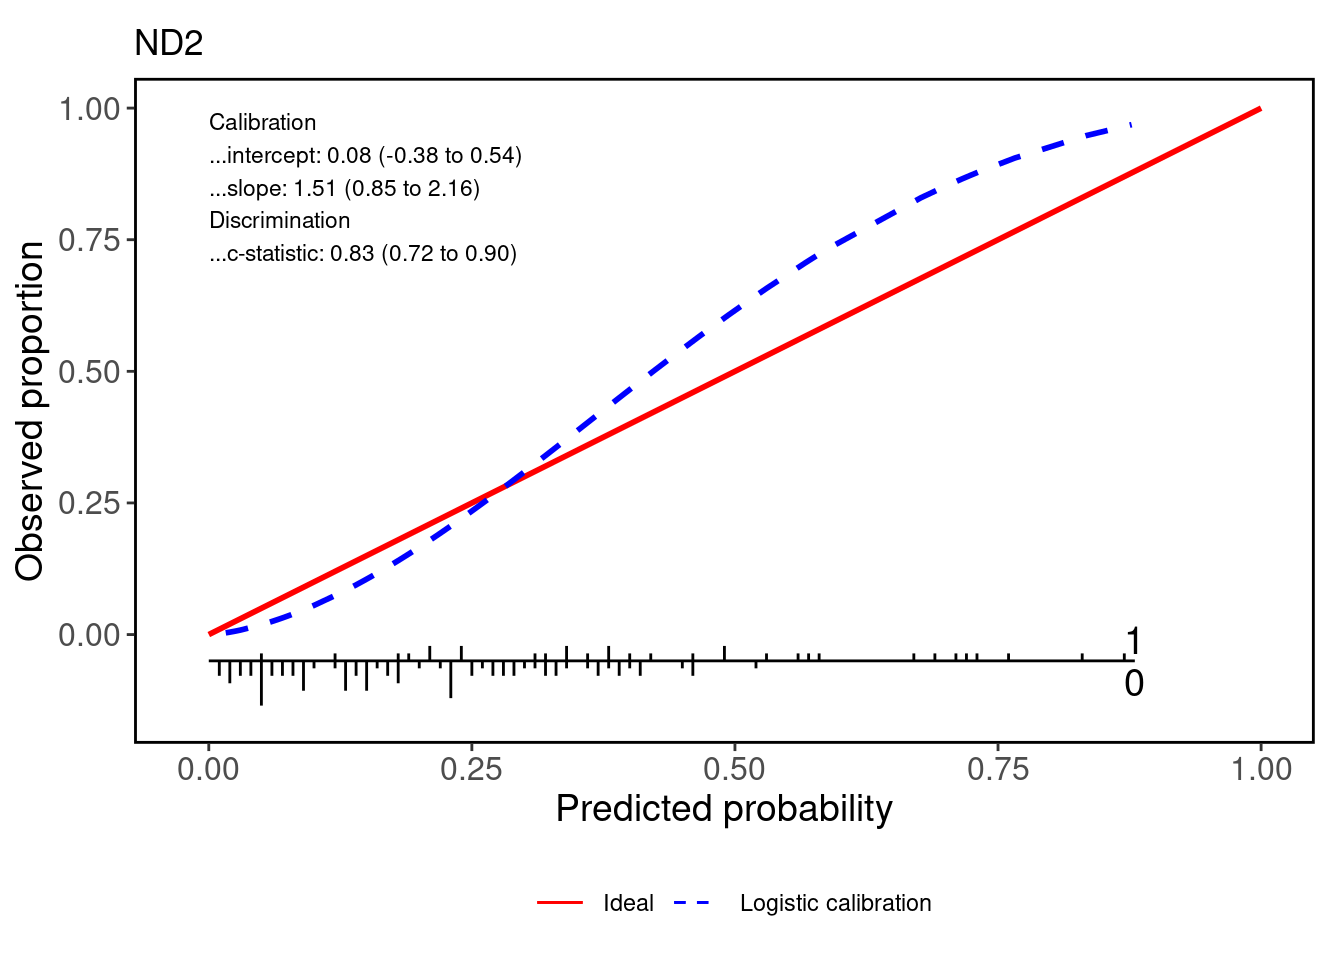


[[3]]

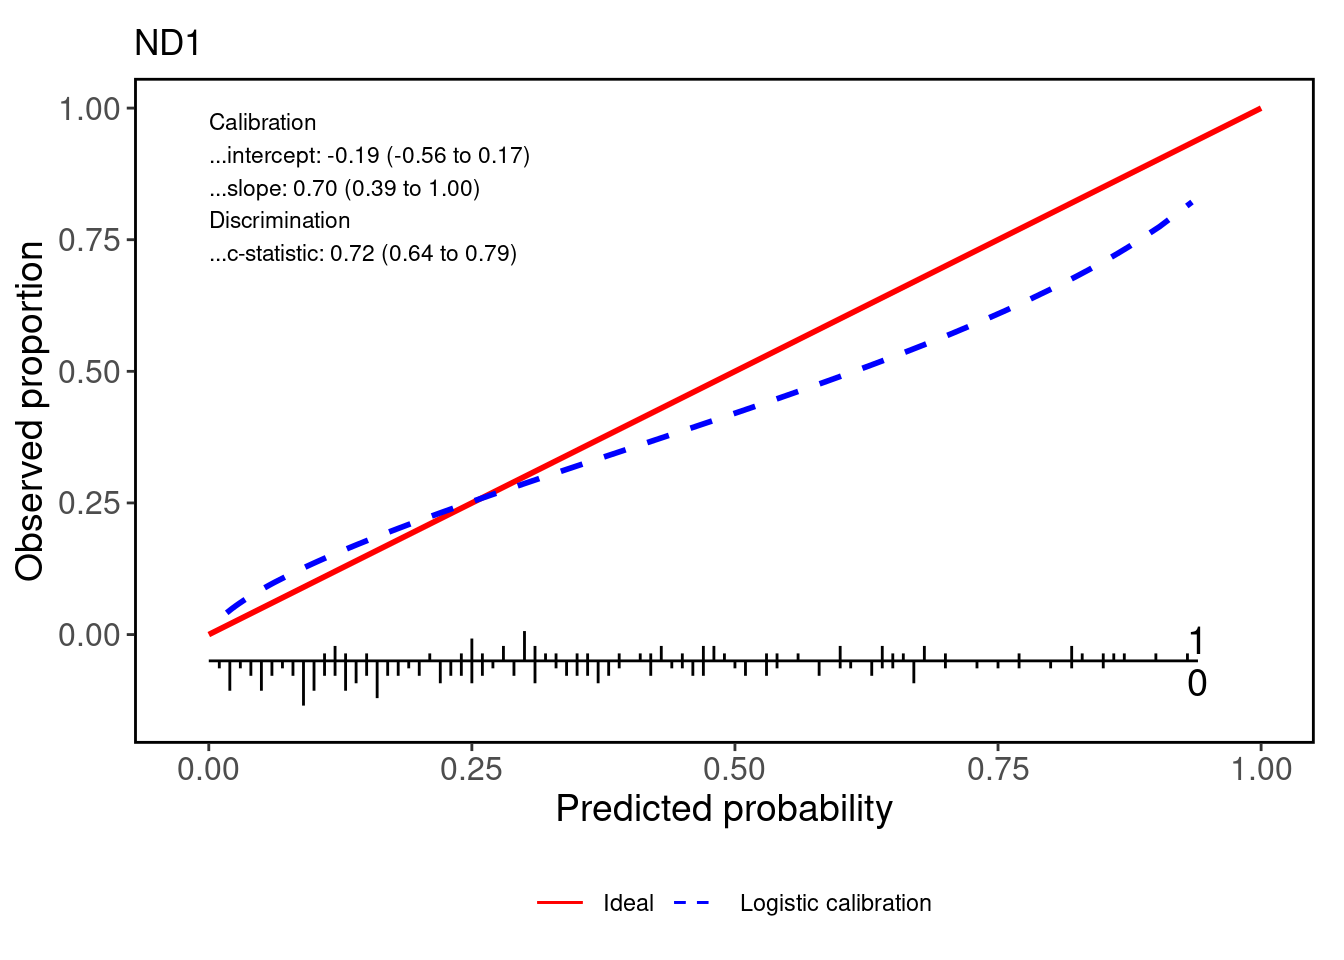


[[4]]

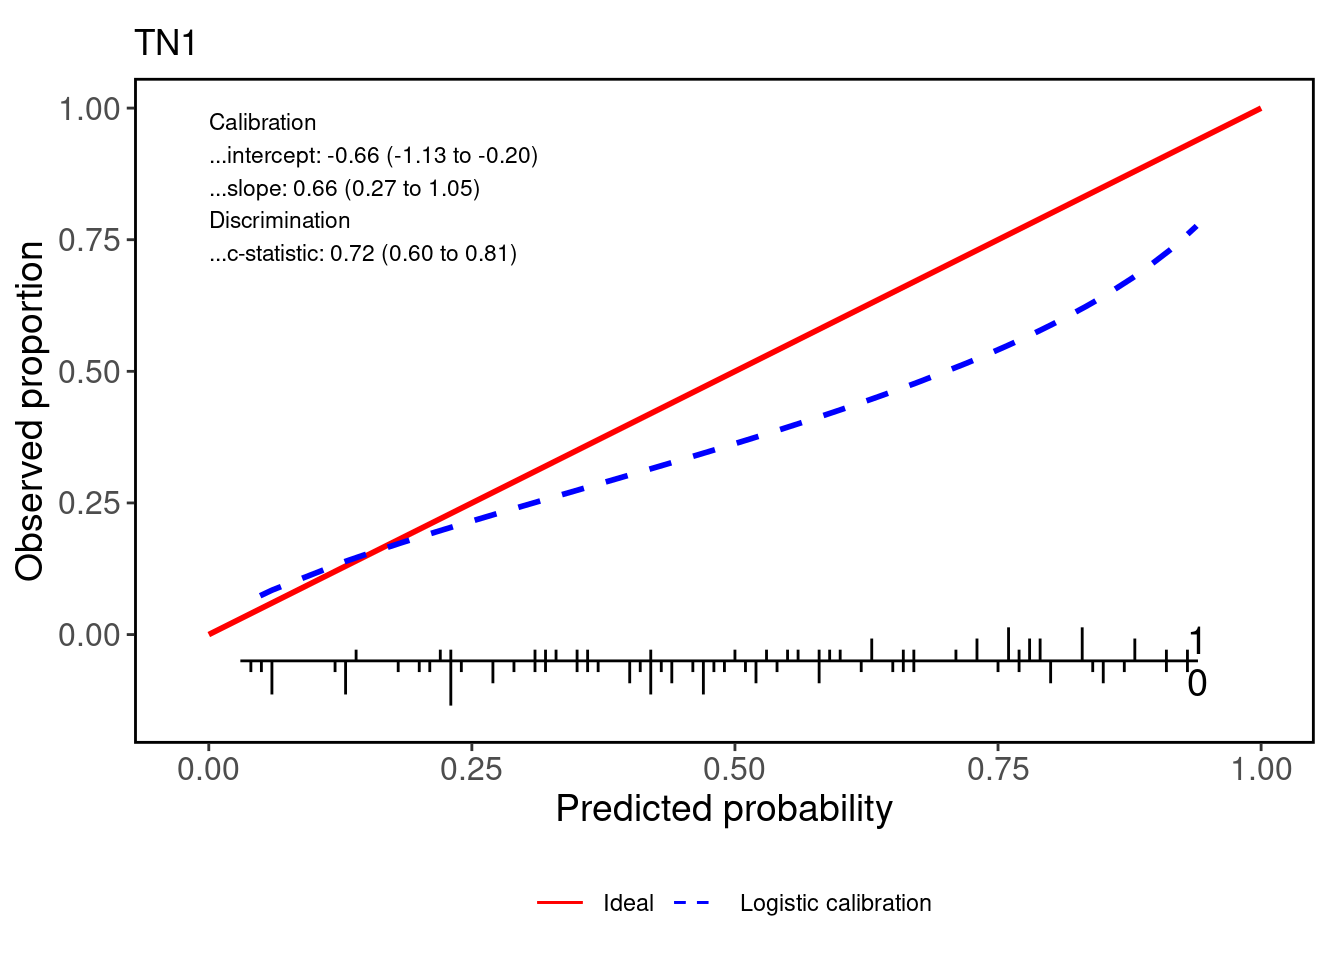


[[5]]

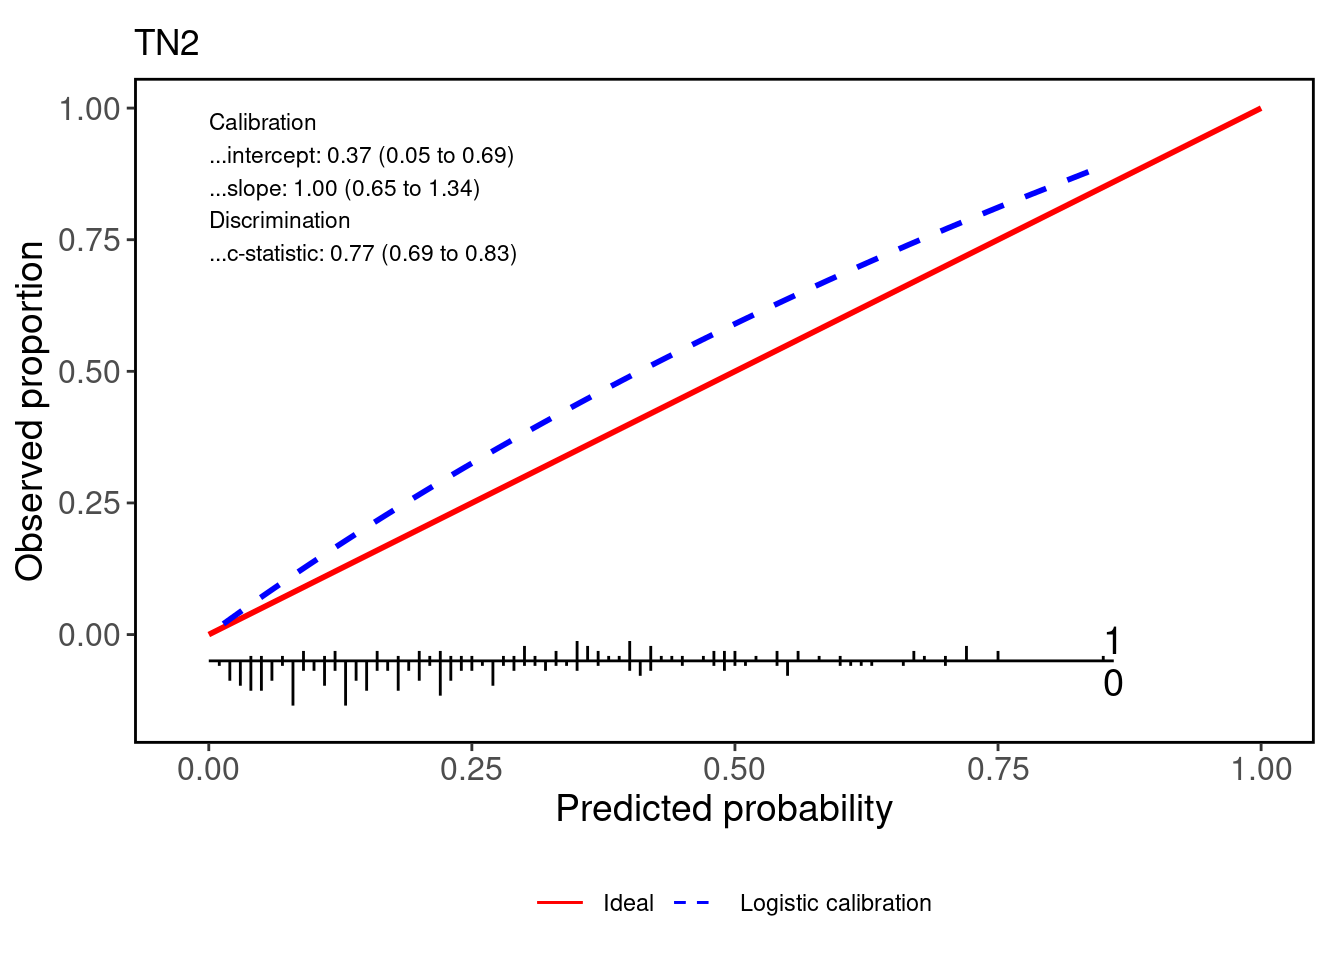


[[6]]

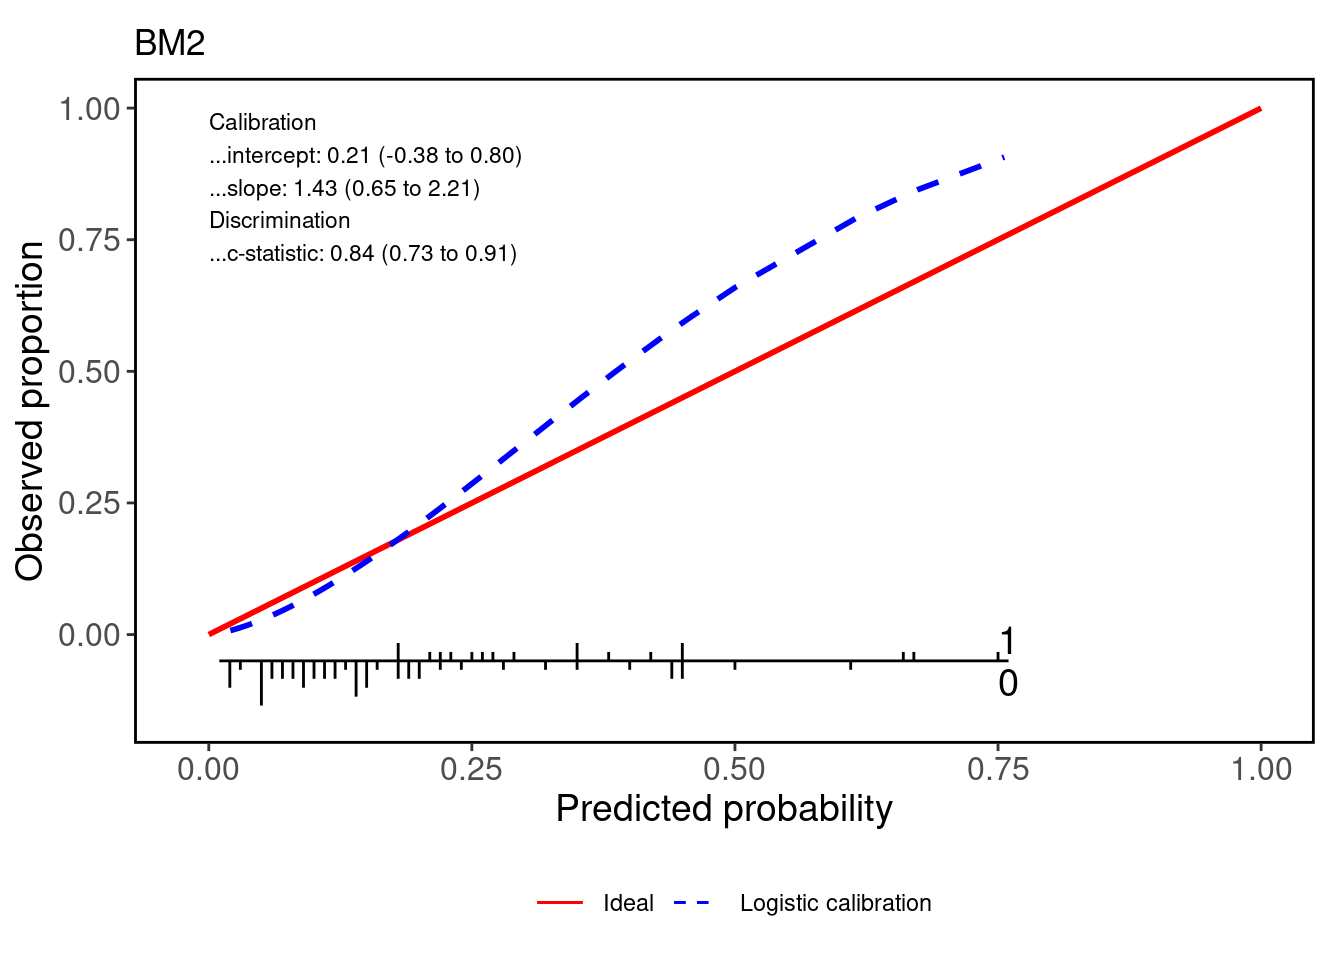

In [ ]:
run_workflow_black_box <- function(sample, model) {
  validation <- predict(model, newdata = assessment(sample), type = "response") |>
    _$fit |>
    as_tibble() |>
    rename(.pred_TRUE = value) |>
    mutate(
      .pred_FALSE = 1 - .pred_TRUE,
      truth = assessment(sample)$flag_ADR_TP_ID |> as.factor()
    ) |>
    relocate(.pred_FALSE)

  auc <- roc_auc(validation, truth, .pred_TRUE, event_level = "second")
  intercept <- cal_intercept(validation, truth, .pred_FALSE)
  slope <- cal_slope(validation, truth, .pred_FALSE)
  bind_rows(auc, intercept, slope)
}

workflow_results_BMA <- map2(cross_samples$splits, cross_black_box, run_workflow_black_box) |>
  set_names(cross_predict_site) |>
  bind_rows(.id = "site") |>
  select(-.estimator) |>
  pivot_wider(names_from = .metric, values_from = .estimate)

calc_cross_performance_black_box <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model, data, type = "response") |> _$fit
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, smooth = "none")

  tibble(
    site = data$site[1],
    n = nrow(data),
    cross_C_index = calperf$Cindex[[1]],
    cross_C_index_lower = calperf$Cindex[[2]],
    cross_C_index_upper = calperf$Cindex[[3]],
    cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
    cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
    cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
    cross_calibration_slope = calperf$Calibration$Slope[[1]],
    cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
    cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
  )
}

cross_estimates_BMA <- map2_dfr(cross_samples$splits, cross_black_box, calc_cross_performance_black_box)

plot_calibration_curve_black_box <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model, data, type = "response") |> _$fit
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 2, col.log = "blue", smooth = "none")
  calperf$ggPlot + ggtitle(data$site[1])
}

cross_plots_BMA <- map2(cross_samples$splits, cross_black_box, plot_calibration_curve_black_box)

cross_plots_BMA


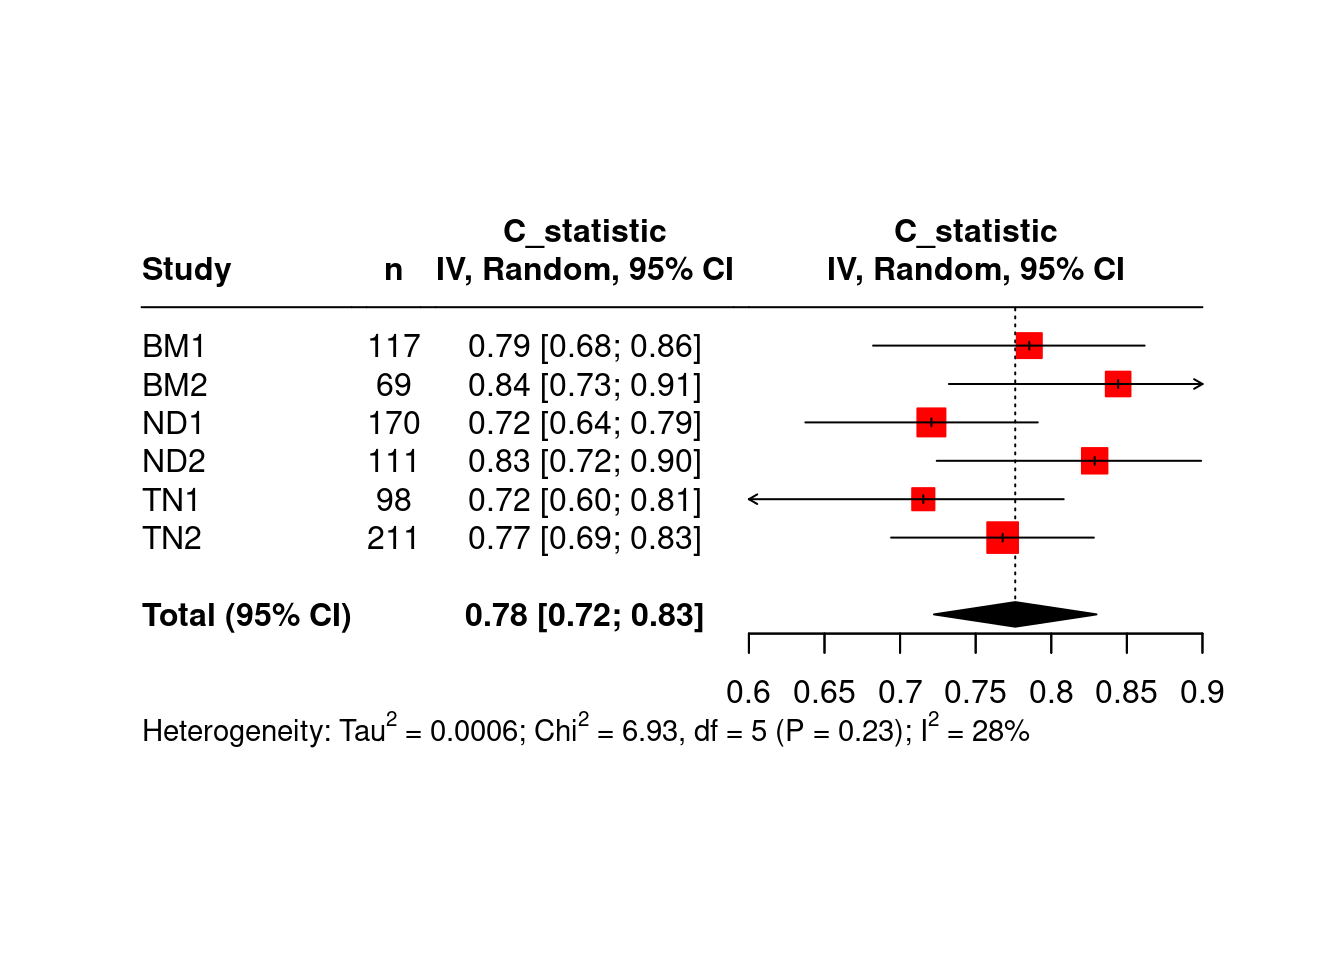

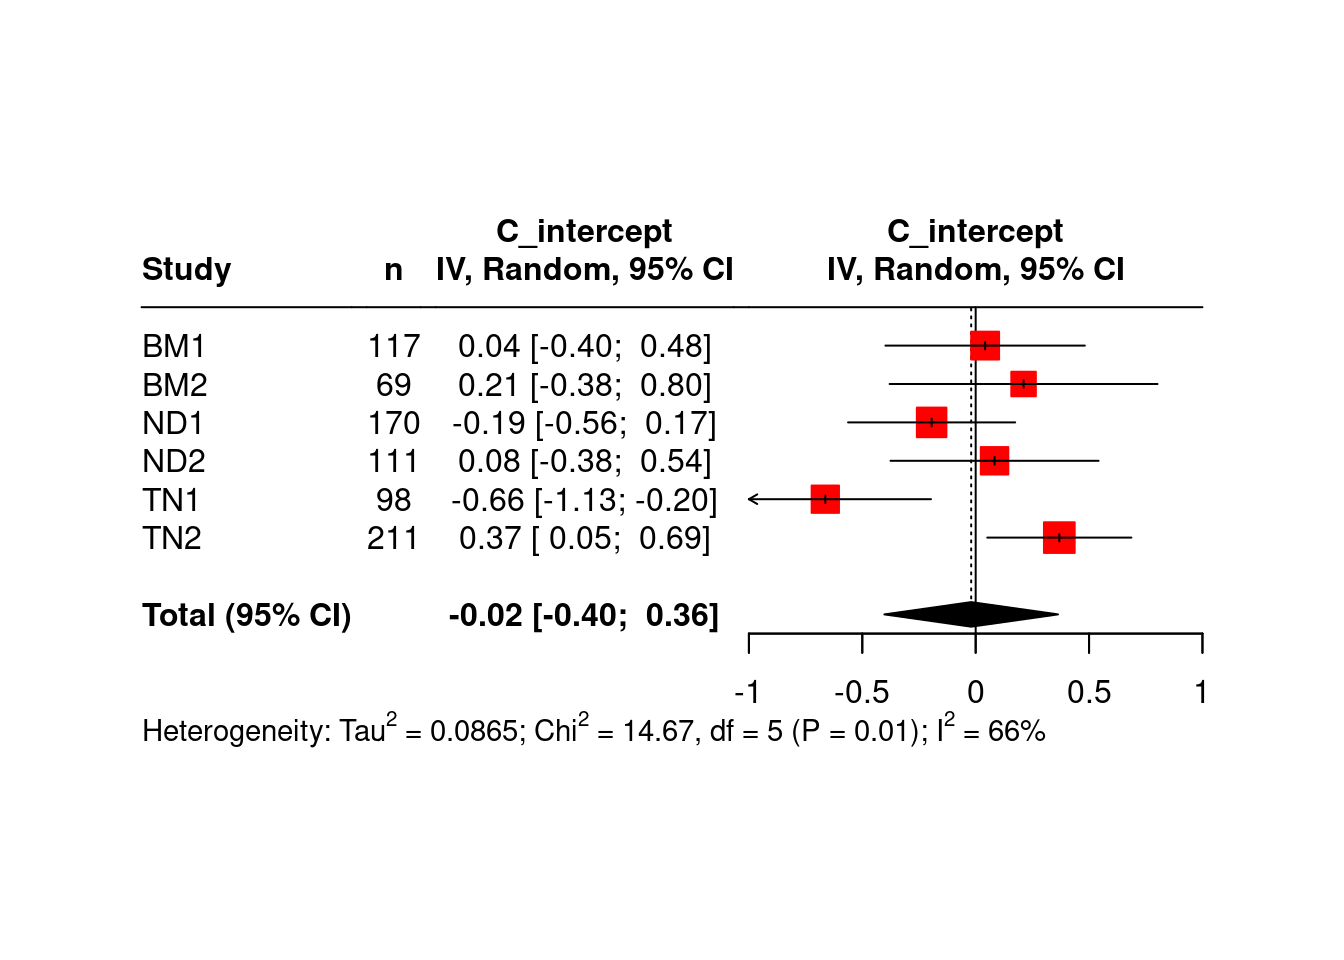

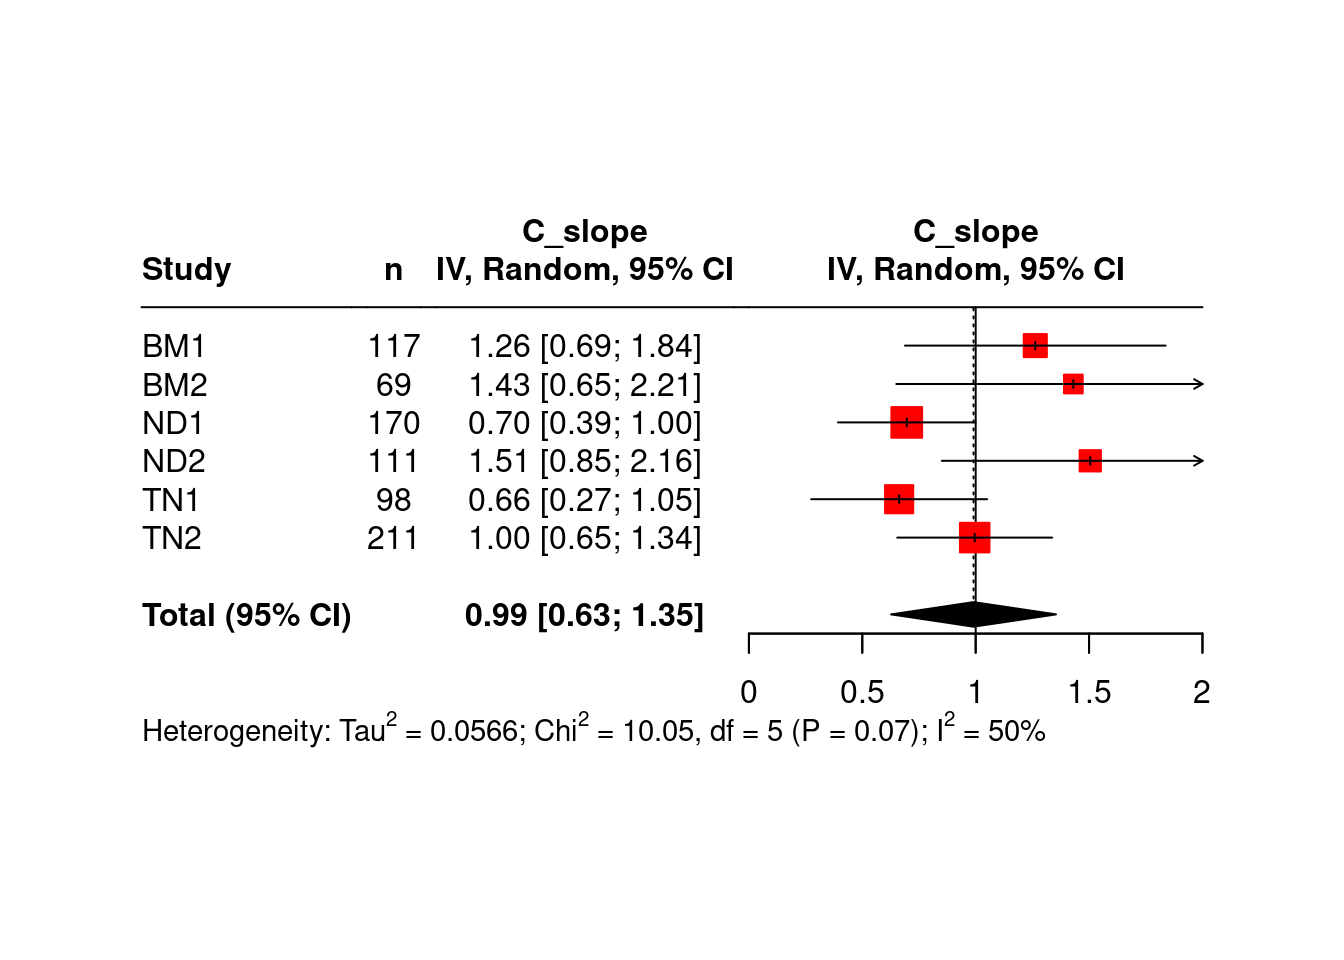

In [ ]:
library(meta)

cross_C_index_meta_BMA <- metagen(
  data = cross_estimates_BMA,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

forest_plot_C_index_BMA <- forest(
  cross_C_index_meta_BMA,
  sortvar = studlab,
  ref = NA,
  xlim = c(0.6, 0.9),
  leftcols = c("studlab", "n", "effect.ci"),
  addrows.below.overall = 2,
  layout = "RevMan5"
)


In [ ]:
save(cross_performance_metrics_BPM, file = "data/model-performance/cross-performance-metrics-BPM.rda")
